In [2]:
import scipy as scp
import numpy as np
import time
import datetime
#from datetime import timedelta
import matplotlib.pyplot as plt

print("libraries imported")

libraries imported


In [3]:
def getTime(mode):
    global start_time0, start_time, end_time0, end_time
    match mode:
        case 'integrateStart':
            start_time0 = time.time()
            start_time = datetime.datetime.fromtimestamp(start_time0)
            return start_time
        case 'integrateEnd':
            end_time0 = time.time()
            end_time = datetime.datetime.fromtimestamp(end_time0)
            return end_time
        case 'current':
            current_time0 = time.time()
            current_time = datetime.datetime.fromtimestamp(current_time0)
            return current_time0, current_time
def printAlligned(message, variable, unit, msgspaces=20, varspaces=30):
    output = print("{:{msgspace}s}= {:{varspace}s} {}".format(message, str(variable), unit, msgspace=msgspaces, varspace=varspaces))
    return output
def debug(level='partial'):
    match level:
        case 'partial':
            print('   DEBUG LEVEL PARTIAL')
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'full':
            print('   DEBUG LEVEL FULL')
            print("List of globals:")
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'constants':
            print('   DEBUG LEVEL CONSTANTS')
            localT = getTime('current')[1]
            printAlligned('Current time', localT, '')
        case 'start':
            print('   DEBUG LEVEL START')
            localT = getTime('integrateStart')
            printAlligned('Start time', localT, 'seconds', msgspaces=15)
            printAlligned('S position',iniSpos, 'm')
            printAlligned('S velocity', iniSvel, 'm s^-1')
        case 'end':
            print('   DEBUG LEVEL END')
            end_time = time.time()
            printAlligned('end_time',end_time, 'seconds', msgspaces=15)
            printAlligned('Wall runtime',end_time-start_time, msgspaces=15)
        case 'none':
            return None

def initialize(mode,inSpos=[0,0],inSvel=[0,0],startdebugmode='start'): 
    # Constants
    match mode:
        case 'constants':
            global GravConst, dEM, mE, mM, mT, rE, rM, PeriodEM, l2Original, l2VelOriginal, drOriginal
            GravConst = 6.6726e-11
            dEM = 3.844e8                                     #Earth-Moon separation
            mE = 5.9742e24                                  #Earth Mass
            mM = 7.35e22                                    #Moon mass
            mT = mE + mM                                    #Barycentre mass
            rE = dEM*mM/mT                                    #Barycentre-Earth separation
            rM = dEM*mE/mT                                    #Barycentre-Moon separation
            PeriodEM = np.sqrt(4 * np.pi**2 * dEM**3 / GravConst / mT)    #Orbital period
            l2Original = rM + dEM*(mM/3/mE)**(1/3)
            l2VelOriginal = 2*np.pi * l2Original / PeriodEM
            drOriginal = dEM*(mM/3/mE)**(1/3)
            return None
        case 'inputs':
            global iniSpos, iniSvel
            iniSpos = np.array(inSpos)
            iniSvel = np.array(inSvel)
            debug(startdebugmode)
            return None
    return 'FAILED TO INITIALIZE'
##initial velocity ???
initialize('constants')


'''unused debug
print(start_time)
printAlligned('S position',Spos)
print("{:20s}= {}".format('S position',Spos))
print("S velocity     = {}".format(Svel))
print("S acceleration = {}".format(Sacc))
print("P = {}".format(P))
print("HR P = {}".format(timedelta(seconds = P)))
'''

def calcEpos(time, loc_rE=rE):
    output = np.array([-loc_rE*np.cos(2*np.pi * time/PeriodEM),-loc_rE*np.sin(2*np.pi * time/PeriodEM)])
    return output
def calcMpos(time, loc_rM=rM):
    output = np.array([loc_rM*np.cos(2*np.pi * time/PeriodEM),loc_rM*np.sin(2*np.pi * time/PeriodEM)])
    return output
def d2t_r(time, x, y):
    loc_mE = mE
    loc_mM = mM
    Epos = calcEpos(time)
    Mpos = calcMpos(time)
    dE = np.sqrt((x - Epos[0])**2 + (y - Epos[1])**2)
    dM = np.sqrt((x - Mpos[0])**2 + (y - Mpos[1])**2)
    x2 = -GravConst*loc_mE*(x - Epos[0])/dE**3 - GravConst*loc_mM*(x - Mpos[0])/dM**3
    y2 = -GravConst*loc_mE*(y - Epos[1])/dE**3 - GravConst*loc_mM*(y - Mpos[1])/dM**3
    Sacc = np.array([x2,y2])
    return Sacc


Main function definitions

In [4]:
def TaylorODEsolve3BP(mode, t_0, t_f, dt, limits=[0,0], progress=True):
    match mode:
        case 'solve':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                Sacc = d2t_r(t, *Spos)
                Spos = Spos + dt * Svel + Sacc * dt**2 / 2
                Svel = Svel + dt * Sacc
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList
        case 'limits':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                '''#Progress bar, not used
                if i% (int(steps/10)) == 0:
                    n = round(i / steps, 2) * 100
                    printAlligned('{}%'.format(n), Spos,'m')
                    printAlligned('{}%'.format(n), Svel,'m s^-1')
                '''
                
                Sacc = d2t_r(t, *Spos)
                Spos = Spos + dt * Svel + Sacc * dt**2 / 2
                Svel = Svel + dt * Sacc
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)

                Sdist = np.sqrt(Spos[0]**2 + Spos[1]**2)
                if Sdist < limits[0]:
                    move = 1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i
                if Sdist > limits[1]:
                    move = -1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            move = 0
            return SposList, MposList, EposList, tList, move, steps


def RK4ODEsolve3BP(mode, t_0, t_f, dt, limits=[0,0], progress=True): #t_0: time initial [seconds], t_f: time final [seconds], dt: time step
    match mode:
        case 'solve':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                w0 = d2t_r(t, *Spos)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, *u1)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, *u2)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, *u3)
                
                match progress:
                    case True:
                        if i% (int(steps/10)) == 0:
                            n = round(i / steps, 2) * 100
                            printAlligned('{}%'.format(n), Spos,'m')
                            printAlligned('{}%'.format(n), Svel,'m s^-1')
                    case False:
                        pass
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            return SposList, MposList, EposList, tList
        case 'limits':
            Spos = iniSpos
            Svel = iniSvel
            steps = int((t_f - t_0) / dt)
            tList = np.arange(t_0, t_f, dt)
            SposList = np.zeros((steps + 1, 2))
            EposList = np.zeros((steps + 1, 2))
            MposList = np.zeros((steps + 1, 2))
            
            t = t_0
            SposList[0] = Spos
            EposList[0] = calcEpos(t_0)
            MposList[0] = calcMpos(t_0)
            for i in range(steps):
                w0 = d2t_r(t, *Spos)
                u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
                v1 = Svel + dt * w0 / 2
                w1 = d2t_r(t + dt/2, *u1)
                u2 = Spos + dt * v1 / 2
                v2 = Svel + dt * w1 / 2
                w2 = d2t_r(t + dt/2, *u2)
                u3 = Spos + dt * v2
                v3 = Svel + dt * w2
                w3 = d2t_r(t + dt, *u3)
                
                '''#progress bar, not in use
                if i% (int(steps/10)) == 0:
                    n = round(i / steps, 2) * 100
                    printAlligned('{}%'.format(n), Spos,'m')
                    printAlligned('{}%'.format(n), Svel,'m s^-1')
                '''
                
                Spos = Spos + dt * (Svel + 2*v1 + 2*v2 + v3) / 6
                Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
                Sdist = np.sqrt(Spos[0]**2 + Spos[1]**2)
                
                t = tList[i+1]
                SposList[i+1] = Spos
                EposList[i+1] = calcEpos(t)
                MposList[i+1] = calcMpos(t)
                if Sdist < limits[0]:
                    move = 1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i
                if Sdist > limits[1]:
                    move = -1
                    SposList = np.transpose(SposList)
                    EposList = np.transpose(EposList)
                    MposList = np.transpose(MposList)
                    return SposList, MposList, EposList, tList, move, i

            SposList = np.transpose(SposList)
            EposList = np.transpose(EposList)
            MposList = np.transpose(MposList)
            move = 0
            return SposList, MposList, EposList, tList, move, steps


def plot(data=None,label='',mode='plot', plotLims=[-5e8,5e8,-5e8,5e8]):
    global ax
    match mode:
        case 'plot':
            ax.plot(*data, label=label)
        case 'axes':
            ax = plt.figure().add_subplot()
            plotLims = ax.axis(plotLims)
            ax.set_aspect('equal',adjustable='box')
            print('plot limits:{}'.format(plotLims))
            plt.axhline(0, color='black')
            plt.axvline(0, color='black')
        case 'show':
            ax.legend()
            plt.show()

def findFFactor(mode, fGuess, dPlaces, tolerance = 1e6, t_f = PeriodEM):
    fGuessStr = str(fGuess)
    print('guess: {}'.format('.' in fGuessStr))
    if ('.' in fGuessStr):
        dPlace = len(fGuessStr.split('.')[1])
    else:
        dPlace = 0
    f = fGuess
    fo = f
    #find length of decimal part
    digit = 0
    n = 1 #factor finding iteration number
    flist = []
    flist.append(f)
    pointslist = []
    match mode:
        case 'RK4':
            while dPlace <= dPlaces:
                dr = drOriginal *f
                l2 = rM + dr
                l2Vel = 2*np.pi * l2 / PeriodEM
                limits = [l2 - tolerance, l2 + tolerance]
                initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
                out = RK4ODEsolve3BP('limits', 0, t_f, 100, limits= limits) #solve in limit mode
                
                move = out[4]
                steps = out[5]
                if move == 1:
                    digit+=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}'.format('move:', str(move), 'steps:',steps))
                elif move == -1:
                    digit-=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    dPlace+=1
                    digit = 0
                    fo = f
                elif move ==0:
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    break
                else:
                    print('ERROR')
                    break
                flist.append(f)
                n+=1
        case 'Taylor':
            while dPlace <= dPlaces:
                dr = drOriginal *f
                l2 = rM + dr
                l2Vel = 2*np.pi * l2 / PeriodEM
                limits = [l2 - tolerance, l2 + tolerance]
                initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
                out = TaylorODEsolve3BP('limits', 0, t_f, 10, limits= limits) #solve in limit mode
                pointslist = [out[i] for i in range(3)]
                move = out[4]
                steps = out[5]
                if move == 1:
                    digit+=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}'.format('move:', str(move), 'steps:',steps))
                elif move == -1:
                    digit-=1
                    f = fo + digit * 10** (-dPlace)
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    dPlace+=1
                    digit = 0
                    fo = f
                elif move ==0:
                    print('{:10s}{:>2.2s}  {:10s}{:10}  {:2s}{:18.12f}  {:2s}{:18}'.format('move:', str(move), 'steps:', steps, 'f:', f,'n:',n))
                    break
                else:
                    print('ERROR')
                    break
                flist.append(f)
                n+=1
    dr = drOriginal *f
    l2 = rM + dr
    l2Vel = 2*np.pi * l2 / PeriodEM
    limits = [l2 - tolerance, l2 + tolerance]
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2Vel],startdebugmode='none')
    out = RK4ODEsolve3BP('limits', 0, t_f, 100, limits= limits)
    pointslist = [out[i] for i in range(4)]
    print('f={} in {} steps'.format(f,n))
    return f, n, flist, pointslist

Full solve

   FULL SOLVE
Start time:         0s   End time:      2357285.9706s   Taylor timestep:     10s   RK4 timestep:       100s
L2 error vector:   ( -549.358081, -4364.473952) m
L2 error distance:  4398.912045 m
Initial Moon-Satellite Separation: 64519610.196479075m
Final Moon-Satellite Separation:   64519060.90831959m
Error on dr:                       0.0006152885329576097m
plot limits:(-500000000.0, 500000000.0, -500000000.0, 500000000.0)


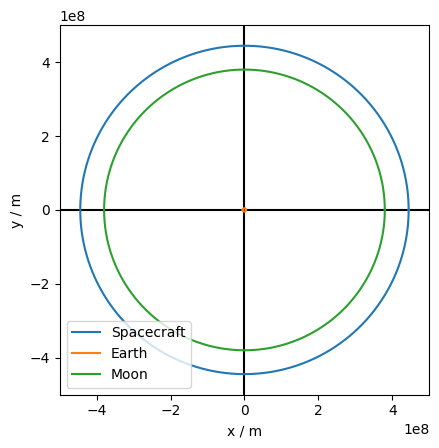

plot limits:(-100000000.0, 100000000.0, -100000000.0, 100000000.0)


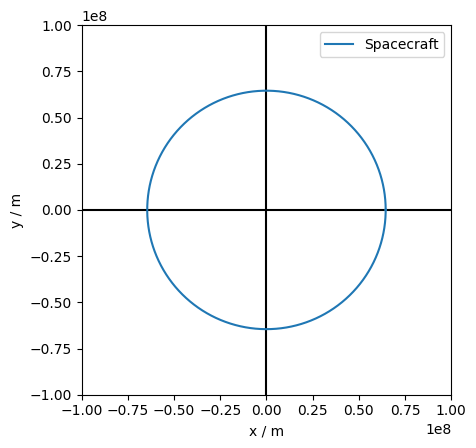

L2 error vector:   (-2406.803400, -100288.676139) m
L2 error distance: 100317.552125 m
Initial Moon-Satellite Separation: 64520115.77906661m
Final Moon-Satellite Separation:   64517720.31086647m
Error on dr:                       0.0006152885329576098m
plot limits:(-500000000.0, 500000000.0, -500000000.0, 500000000.0)


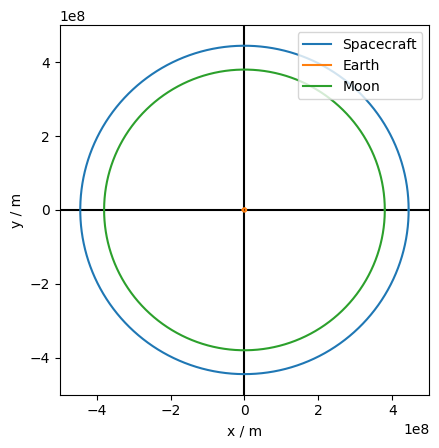

plot limits:(-100000000.0, 100000000.0, -100000000.0, 100000000.0)


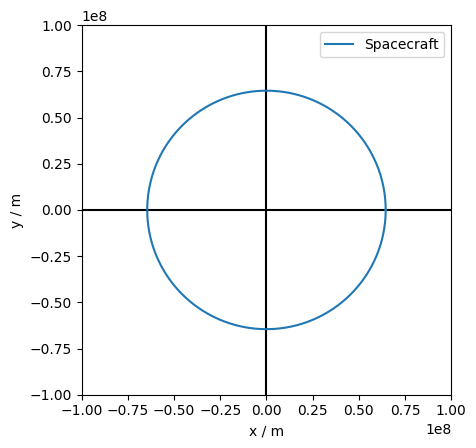

In [5]:
def full_solve(t_0, t_f, dtTaylor,dtRK4):
    print('   FULL SOLVE')
    print('{:11s}{:10}s   {:9s}{:18.4f}s   {:18s}{:5}s   {:18s}{:5}s'.format('Start time:', t_0, 'End time:', t_f, 'Taylor timestep:', dtTaylor,'RK4 timestep:',dtRK4))
    global fRK4, fTaylor
    fTaylor = 1.0486073889
    fRK4    = 1.0486156059
    #fRK4    = 1.04859279325 #NOT WORKING

    
    dr = drOriginal *fTaylor
    l2 = rM + dr
    l2vel = 2*np.pi * l2 / PeriodEM

    initialize('constants')
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2vel], startdebugmode='none')
    SposList, MposList, EposList, tList = TaylorODEsolve3BP('solve', t_0, t_f, dtTaylor, progress=False)
    
    ManipulateSposList = np.transpose(SposList)
    errorVector = ManipulateSposList[-1] - ManipulateSposList[0]
    errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)
    ManipulateMposList = np.transpose(MposList)
    MSfinalSeparationVector = ManipulateMposList[-1] - ManipulateSposList[-1]
    MSfinalSeparationDist = np.sqrt(MSfinalSeparationVector[0]**2 + MSfinalSeparationVector[1]**2)
    print('L2 error vector:   ({:12f}, {:12f}) m'.format(*errorVector))
    print('L2 error distance: {:12f} m'.format(errorDist))
    print('Initial Moon-Satellite Separation: {}m'.format(dr))
    print('Final Moon-Satellite Separation:   {}m'.format(MSfinalSeparationDist))
    print('Error on dr:                       {}m'.format(1e-11/fTaylor*dr))
    plot(mode='axes')
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SposList,label='Spacecraft')
    plot(data=EposList,label='Earth')
    plot(data=MposList,label='Moon')
    plot(mode='show')
    SLunCoordPos = SposList - MposList
    ELunCoordPos = EposList - MposList
    plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SLunCoordPos, label='Spacecraft')
    plot(mode='show')

    #f = 1.04859279325
    #f  = 1.0486156059

    dr = drOriginal *fRK4
    l2 = rM + dr
    l2vel = 2*np.pi * l2 / PeriodEM

    initialize('constants')
    initialize('inputs',inSpos=[l2,0],inSvel=[0, l2vel], startdebugmode='none')
    SposList, MposList, EposList, tList = RK4ODEsolve3BP('solve', t_0, t_f, dtRK4, progress=False)

    ManipulateSposList = np.transpose(SposList)
    errorVector = ManipulateSposList[-1] - ManipulateSposList[0]
    errorDist = np.sqrt(errorVector[0]**2 + errorVector[1]**2)
    ManipulateMposList = np.transpose(MposList)
    MSfinalSeparationVector = ManipulateMposList[-1] - ManipulateSposList[-1]
    MSfinalSeparationDist = np.sqrt(MSfinalSeparationVector[0]**2 + MSfinalSeparationVector[1]**2)
    print('L2 error vector:   ({:12f}, {:12f}) m'.format(*errorVector))
    print('L2 error distance: {:12f} m'.format(errorDist))
    print('Initial Moon-Satellite Separation: {}m'.format(dr))
    print('Final Moon-Satellite Separation:   {}m'.format(MSfinalSeparationDist))
    print('Error on dr:                       {}m'.format(1e-11/fRK4*dr))

    plot(mode='axes')
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SposList,label='Spacecraft')
    plot(data=EposList,label='Earth')
    plot(data=MposList,label='Moon')
    plot(mode='show')
    SLunCoordPos = SposList - MposList
    ELunCoordPos = EposList - MposList
    plot(mode='axes',plotLims=[-1e8,1e8,-1e8,1e8])
    plt.xlabel('x / m')
    plt.ylabel('y / m')
    plot(data=SLunCoordPos, label='Spacecraft')
    plot(mode='show')
    

full_solve(0, PeriodEM, 10, 100)

FFactor algorithm Taylor

In [ ]:
initialize('constants')
out = findFFactor('Taylor',1 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fTaylor = out[0]
out = findFFactor('Taylor',local_fTaylor, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fTaylor)

FFactor algorithm RK4

In [ ]:
initialize('constants')
out = findFFactor('RK4',1 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fRK4 = out[0]
out = findFFactor('RK4',local_fRK4, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fRK4)

Verification of FFactor

In [ ]:
fTaylor = 1.0486073889
fRK4    = 1.0486156059

initialize('constants')

out = findFFactor('RK4',fRK4 , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fRK4 = out[0]
out = findFFactor('RK4',fRK4, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fRK4)

out = findFFactor('Taylor',fTaylor , 10,tolerance=1e5,t_f=2*PeriodEM)
local_fTaylor = out[0]
out = findFFactor('Taylor',fTaylor, 10,tolerance=1e5, t_f=PeriodEM)
print(out[0] == fTaylor)